In [175]:

# !pip install pyxdf
# !pip install mne
# !pip install pandas
# !pip install --upgrade jupyterlab ipympl ipywidgets
# !pip install scikit-learn
# !pip install seaborn

In [176]:
import sys
print(sys.version)

3.12.7 | packaged by Anaconda, Inc. | (main, Oct  4 2024, 13:17:27) [MSC v.1929 64 bit (AMD64)]


In [177]:
import pyxdf
import numpy as np
import mne
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from psychopy_experiments.brand_associations.brands_wordlist import WORDLIST
from pathlib import Path

In [178]:
instagram_wordlist = WORDLIST['instagram']
linkedin_wordlist = WORDLIST['linkedin']
unrelated_wordlist = WORDLIST['unrelated']
CATEGORY_MAP = {item: k for k, v in WORDLIST.items() for item in v}

In [179]:
csv_data = pd.read_csv('psychopy_experiments/brand_associations/levan_brand.csv')
# csv_data = pd.read_csv('data/nani_n400.csv')
csv_data

,timestamp_iso,trial_index,brand,target,prime_time_s,target_time_s,resp_window_s,resp_key,rt_ms_from_target
0,2025-12-04T06:21:23.449,0,instagram,კონტაქტი,0.16,0.16,1.5,NaN,NaN
1,2025-12-04T06:21:26.347,1,instagram,ლაიქი,0.16,0.16,1.5,right,1312.00
2,2025-12-04T06:21:29.261,2,instagram,სივი,0.16,0.16,1.5,NaN,NaN
3,2025-12-04T06:21:32.191,3,instagram,ლურჯი,0.16,0.16,1.5,NaN,NaN
4,2025-12-04T06:21:35.171,4,linkedin,ბალიში,0.16,0.16,1.5,NaN,NaN
...,...,...,...,...,...,...,...,...,...
115,2025-12-04T06:27:06.068,115,linkedin,აგური,0.16,0.16,1.5,left,313.33
116,2025-12-04T06:27:08.965,116,instagram,აგური,0.16,0.16,1.5,right,267.84
117,2025-12-04T06:27:11.879,117,instagram,რილსები,0.16,0.16,1.5,NaN,NaN
118,2025-12-04T06:27:14.793,118,instagram,ვიდეოები,0.16,0.16,1.5,NaN,NaN


In [180]:
# subject_name = Path(xdf_path).stem.replace('_brand', '').capitalize()

In [181]:
csv_data['category'] = csv_data['target'].map(CATEGORY_MAP).fillna('unknown')

In [182]:
xdf_path = 'psychopy_experiments/brand_associations/levan_brand.xdf'
xdf_data = pyxdf.load_xdf(xdf_path)[0]
markers = xdf_data[0]
eeg = xdf_data[1]
subject_name = Path(xdf_path).stem.replace('_brand', '').capitalize()

In [183]:
# Redefine for Luka's data
# xdf_path = './data/luka_n400.xdf'
# xdf_data = pyxdf.load_xdf(xdf_path)[0]
# markers = xdf_data[0]
# eeg = xdf_data[1]

In [184]:
# Read marker data
marker_time = markers['time_stamps']
time_offset = marker_time[0]
marker_time = marker_time - time_offset
marker_data = [x[0] for x in markers['time_series']]

In [185]:
# n400_data = ExperimentData('data/nani_n400.xdf')

In [186]:
CONST_OFFSET = 0.073  # Delay measured with photodiode that day

In [187]:
eeg_time = eeg['time_stamps']
eeg_time = eeg_time - time_offset - CONST_OFFSET
eeg_data = eeg['time_series'][:, :8]

In [188]:
# Create raw data
info = mne.create_info(ch_names=['Fz', 'C3', 'Cz', 'C4', 'Pz', 'PO7', 'Oz', 'PO8'], ch_types=['eeg'] * 8,
                       sfreq=250)
raw = mne.io.RawArray([1e-6 * eeg_data[:, i] for i in range(8)], info)
raw.notch_filter(freqs=[50])
raw.filter(0.5, 30)
raw

Creating RawArray with float64 data, n_channels=8, n_times=113720


    Range : 0 ... 113719 =      0.000 ...   454.876 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidt

<RawArray | 8 x 113720 (454.9 s), ~7.0 MiB, data loaded>

### ICA

In [189]:
# raw.set_montage("standard_1020", match_case=False)
# raw.set_eeg_reference("average")

# ica = ICA(n_components= None, random_state=42, method="fastica")
# ica.fit(raw)


# ica.plot_components()      
# # ica.plot_sources(raw, start=0, stop=20)


# eog_inds, scores = ica.find_bads_eog(raw, ch_name='Fz', threshold=2.0)
# ica.exclude = eog_inds


# raw = ica.apply(raw.copy())



In [190]:
TARGET_MARKER = 1
RESPONSE_MARKER = 2

In [191]:
# events = []
# for i, marker in enumerate(marker_data):
#     eeg_start_index = np.searchsorted(eeg_time, marker_time[i], side="left")
#     eeg_start_index = np.clip(eeg_start_index, 0, len(eeg_time)-1)
#     events.append([eeg_start_index, 0, marker])

# events = np.asarray(events, dtype=int)
# events = events[:-1]                
# events = events[events[:, 2] == 1]  
# events


In [192]:
events = []
for i, marker in enumerate(marker_data):
    eeg_start_index = np.argmax(eeg_time >= marker_time[i]) - 1
    events.append([eeg_start_index, 0, marker])
events = np.array(events)
# NOTE: We remove the last event because it is an artifact (end of recording)
events = events[:-1, :]
events = events[events[:, 2] == 1]
events

array([[ 17603,      0,      1],
       [ 18331,      0,      1],
       [ 19055,      0,      1],
       [ 19784,      0,      1],
       [ 20529,      0,      1],
       [ 21265,      0,      1],
       [ 21998,      0,      1],
       [ 22730,      0,      1],
       [ 23467,      0,      1],
       [ 24200,      0,      1],
       [ 24936,      0,      1],
       [ 25669,      0,      1],
       [ 26401,      0,      1],
       [ 27134,      0,      1],
       [ 27867,      0,      1],
       [ 28599,      0,      1],
       [ 29336,      0,      1],
       [ 30068,      0,      1],
       [ 30796,      0,      1],
       [ 31525,      0,      1],
       [ 32253,      0,      1],
       [ 32981,      0,      1],
       [ 33710,      0,      1],
       [ 34434,      0,      1],
       [ 35171,      0,      1],
       [ 35899,      0,      1],
       [ 36623,      0,      1],
       [ 37356,      0,      1],
       [ 38080,      0,      1],
       [ 38812,      0,      1],
       [ 3

In [193]:
# Define reject criteria
reject_criteria = dict(
    eeg=100e-6,  # 100 µV
)

In [194]:
picks = ["Cz", "Pz"]
event_dict = dict(target=1)
tmin, tmax = -0.2, 1.01
epochs = mne.Epochs(raw.copy(), events, event_id=event_dict, tmin=tmin, tmax=tmax, preload=True,
                    baseline=(None, 0 if tmin < 0 else None), picks=picks, reject=reject_criteria)

Not setting metadata
120 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 120 events and 303 original time points ...
    Rejecting  epoch based on EEG : ['Cz', 'Pz']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['Cz', 'Pz']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['Cz', 'Pz']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['Pz']
    Rejecting  epoch based on EEG : ['Pz']
    Rejecting  epoch based on EEG : ['Cz', 'Pz']
    Rejecting  epoch based on EEG : ['Cz', 'Pz']
    Rejecting  epoch based on EEG : ['Cz', 'Pz']
12 bad epochs dropped


In [195]:
# Get indices for non-rejected epochs
# drop_log = epochs.drop_log
# drop_log_not_ignored = [log for log in drop_log if 'IGNORED' not in log] #ignored არ იქნება ისედაც
# good_epoch_indices = [i for (i, log) in enumerate(drop_log) if len(log) == 0]

In [196]:
drop_log = epochs.drop_log
good_epoch_indices = epochs.selection

In [197]:
good_idx = epochs.selection  # indices into the ORIGINAL events/csv rows

csv_data = csv_data.iloc[good_idx].reset_index(drop=True)
events = events[good_idx]
csv_data


,timestamp_iso,trial_index,brand,target,prime_time_s,target_time_s,resp_window_s,resp_key,rt_ms_from_target,category
0,2025-12-04T06:21:26.347,1,instagram,ლაიქი,0.16,0.16,1.5,right,1312.00,instagram
1,2025-12-04T06:21:29.261,2,instagram,სივი,0.16,0.16,1.5,NaN,NaN,linkedin
2,2025-12-04T06:21:32.191,3,instagram,ლურჯი,0.16,0.16,1.5,NaN,NaN,linkedin
3,2025-12-04T06:21:38.103,5,linkedin,ლაქტოზა,0.16,0.16,1.5,NaN,NaN,unrelated
4,2025-12-04T06:21:41.032,6,linkedin,ბალიში,0.16,0.16,1.5,left,1479.57,unrelated
...,...,...,...,...,...,...,...,...,...,...
103,2025-12-04T06:27:06.068,115,linkedin,აგური,0.16,0.16,1.5,left,313.33,unrelated
104,2025-12-04T06:27:08.965,116,instagram,აგური,0.16,0.16,1.5,right,267.84,unrelated
105,2025-12-04T06:27:11.879,117,instagram,რილსები,0.16,0.16,1.5,NaN,NaN,instagram
106,2025-12-04T06:27:14.793,118,instagram,ვიდეოები,0.16,0.16,1.5,NaN,NaN,instagram


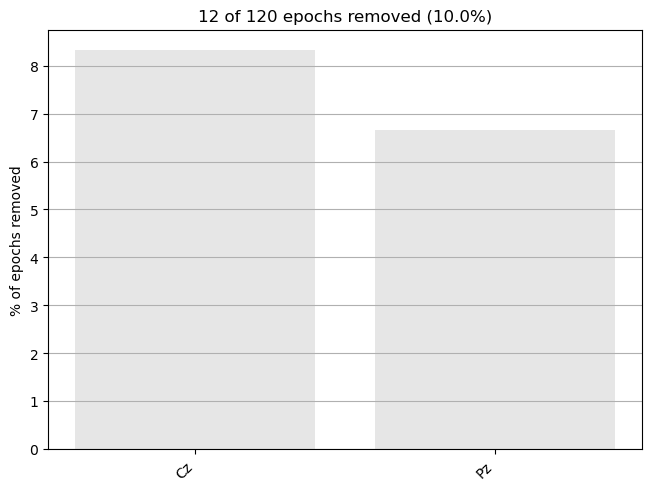

In [198]:
epochs.plot_drop_log(show=True);

In [76]:
# Optional: leave only first unique occurrence of each brand x target pairs
first_indices = csv_data[['brand', 'target']].drop_duplicates(keep='first').index.values
# first_indices = csv_data[['brand', 'target']].drop_duplicates(keep='last').index.values
csv_data = csv_data.iloc[first_indices].reset_index(drop=True)
epochs = epochs[first_indices]
events = events[first_indices]

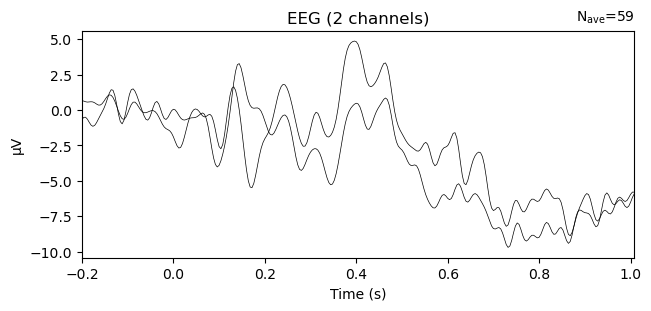

In [77]:
epochs.average().plot(picks=picks)
plt.show()

combining channels using "mean"


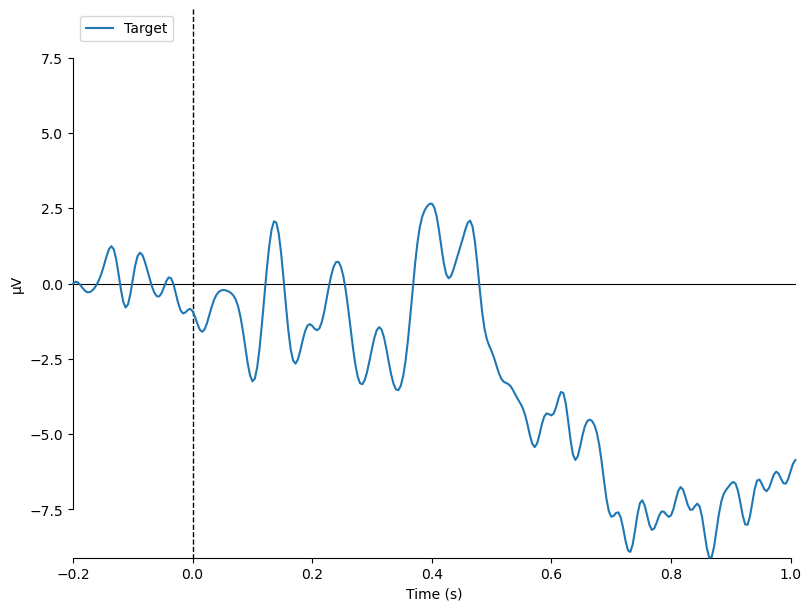

[<Figure size 800x600 with 1 Axes>]

In [78]:
mne.viz.plot_compare_evokeds(
    {"Target": epochs['target'].average()},
    combine='mean',
    show=True
)

In [208]:

# has_resp & 
# has_resp & 
# has_resp & 
# has_resp & 
# has_resp & 
# has_resp &

# has_resp = csv_data["resp_key"]
# .notna().to_numpy()

is_ig_brand = (csv_data["brand"].str.lower() == "instagram").to_numpy()
is_li_brand = (csv_data["brand"].str.lower() == "linkedin").to_numpy()

is_ig_word = csv_data["target"].isin(instagram_wordlist).to_numpy()
is_li_word = csv_data["target"].isin(linkedin_wordlist).to_numpy()
is_un_word = csv_data["target"].isin(unrelated_wordlist).to_numpy()

ig_ig_idx = np.where(is_ig_brand & is_ig_word)[0]
ig_li_idx = np.where(is_ig_brand & is_li_word)[0]
ig_un_idx = np.where(is_ig_brand & is_un_word)[0]

li_li_idx = np.where(is_li_brand & is_li_word)[0]
li_ig_idx = np.where(is_li_brand & is_ig_word)[0]
li_un_idx = np.where(is_li_brand & is_un_word)[0]

ig_instagram = epochs[ig_ig_idx]
ig_linkedin  = epochs[ig_li_idx]
ig_unrelated = epochs[ig_un_idx]


li_instagram = epochs[li_ig_idx]  
li_linkedin  = epochs[li_li_idx]  
li_unrelated = epochs[li_un_idx]  


is_unrelated = csv_data["target"].isin(unrelated_wordlist).to_numpy()
is_related = (
    (csv_data["brand"] == "instagram") & csv_data["target"].isin(instagram_wordlist) |
    (csv_data["brand"] == "linkedin") & csv_data["target"].isin(linkedin_wordlist)
)

unrelated = np.where(is_unrelated)[0]
related =   np.where(is_related)[0]

In [ ]:
instagram_idx = csv_data[csv_data['brand'] == 'instagram'].index.values
linkedin_idx = csv_data[csv_data['brand'] == 'linkedin'].index.values

instagram_words_idx = csv_data[csv_data['target'].isin(instagram_wordlist)].index.values
linkedin_words_idx = csv_data[csv_data['target'].isin(linkedin_wordlist)].index.values
unrelated_words_idx = csv_data[csv_data['target'].isin(unrelated_wordlist)].index.values

response_idx = csv_data[~csv_data['resp_key'].isna()].index.values

# Interesting epochs:
# 1. Everything with response
# 2. For each brand (facebook_idx, youtube_idx):
# 2.1. Facebook words (facebook_words_idx)
# 2.2. Youtube words (youtube_words_idx)
# 2.3. Shared words (shared_words_idx)
# 2.4. Unrelated words (unrelated_words_idx)
filt_ig_idx = np.intersect1d(response_idx, instagram_idx)
filt_li_idx = np.intersect1d(response_idx, linkedin_idx)
ig_ig_words_idx = np.intersect1d(filt_ig_idx, instagram_words_idx)
ig_li_words_idx = np.intersect1d(filt_ig_idx, linkedin_words_idx)
ig_un_words_idx = np.intersect1d(filt_ig_idx, unrelated_words_idx)
li_ig_words_idx = np.intersect1d(filt_li_idx, instagram_words_idx)
li_li_words_idx = np.intersect1d(filt_li_idx, linkedin_words_idx)
li_un_words_idx = np.intersect1d(filt_li_idx, unrelated_words_idx)
ig_instagram = epochs[ig_ig_words_idx]
ig_linkedin = epochs[ig_li_words_idx]
ig_unrelated = epochs[ig_un_words_idx]
li_instagram = epochs[li_ig_words_idx]
li_linkedin = epochs[li_li_words_idx]
li_unrelated = epochs[li_un_words_idx]

In [107]:
unrelated = np.intersect1d(response_idx, unrelated_words_idx)
related = np.union1d(ig_ig_words_idx, li_li_words_idx)

combining channels using "mean"
combining channels using "mean"


combining channels using "mean"


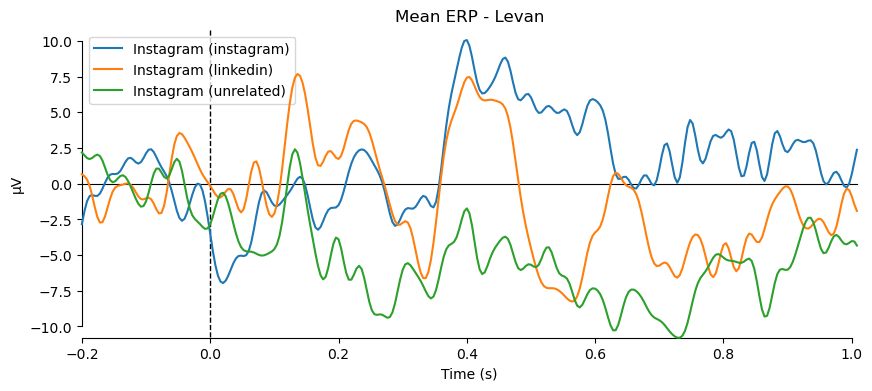

In [206]:
brand = Path(xdf_path).stem.replace('_brand', '').capitalize()

fig, ax = plt.subplots(figsize=(10, 4))
mne.viz.plot_compare_evokeds(
    {"Instagram (instagram)": ig_instagram.average(),
     "Instagram (linkedin)": ig_linkedin.average(),
     "Instagram (unrelated)": ig_unrelated.average()},
    picks=picks,
    combine='mean',
    axes=ax,
    show=False,          
)

ax.set_title(f"Mean ERP - {subject_name}")  
plt.show()


combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


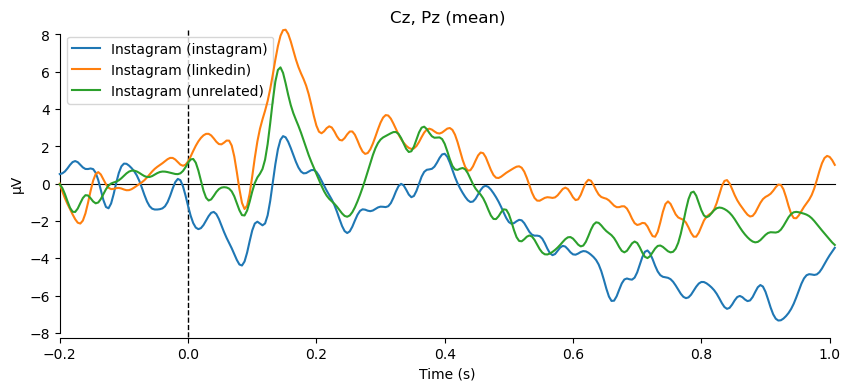

In [ ]:
# fig, ax = plt.subplots(figsize=(10, 4))
# mne.viz.plot_compare_evokeds(
#     {"Instagram (instagram)": ig_instagram.average(), "Instagram (linkedin)": ig_linkedin.average(),
#     "Instagram (unrelated)": ig_unrelated.average()},
#     picks=picks,
#     combine='mean',
#     show=True,
#     axes=ax
# )

# fig = ax.get_figure()


combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


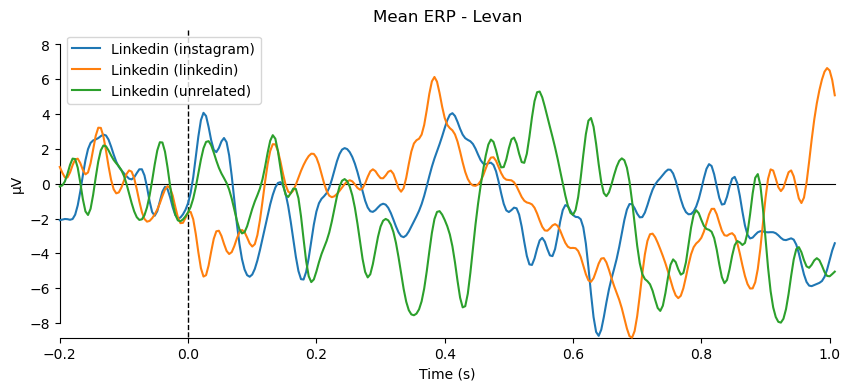

In [209]:
fig, ax = plt.subplots(figsize=(10, 4))
mne.viz.plot_compare_evokeds(
    {"Linkedin (instagram)": li_instagram.average(), "Linkedin (linkedin)": li_linkedin.average(),
    "Linkedin (unrelated)": li_unrelated.average()},
    picks=picks,
    combine='mean',
    axes=ax,
    show=False,          
)

ax.set_title(f"Mean ERP - {subject_name}")  
plt.show()

## Z-Score Plots

In [57]:
# import numpy as np
# import mne
# from sklearn.preprocessing import StandardScaler

# # --------------------------------------------------------
# # 0. Assume you already have:
# #    - epochs: MNE Epochs, shape (n_trials, n_channels, n_times)
# #    - epochs.metadata["category"] with values like "Television", "Relaxation", "Price", "Unrelated"
# #    - epochs.metadata["subject"] with subject IDs
# # --------------------------------------------------------

# # 1) Select unrelated trials to build the N400 template
# unrel_epochs = epochs[unrelated]
# # if len(unrel_epochs) < 30:
# #     raise ValueError(f"Not enough unrelated trials to build a template. ({len(unrel_epochs)})")

# # 2) Compute the average ERP of unrelated trials
# unrel_evoked = unrel_epochs.average()  # shape (n_channels, n_times)
# data = unrel_evoked.data  # numpy array

In [58]:
# # 3) Define N400 time window (adjust to your data!)
# # typical N400: 300–500 ms
# tmin_n400, tmax_n400 = 0.3, 0.5
# tmask = (unrel_evoked.times >= tmin_n400) & (unrel_evoked.times <= tmax_n400)

# # 4) Build temporal template = average over channels in N400 window
# temporal_template = data.mean(axis=0)[tmask]  # shape (n_times_in_window,)
# # normalize to avoid scaling issues
# temporal_template = temporal_template / np.linalg.norm(temporal_template)

# # 5) Build spatial template = average over time in N400 window
# spatial_template = data[:, tmask].mean(axis=1)  # shape (n_channels,)
# spatial_template = spatial_template / np.linalg.norm(spatial_template)

In [59]:
# # (This gives us separate spatial and temporal “shapes” of the N400)

# # --------------------------------------------------------
# # 6) Now compute a single-trial N400 “score” for every NON-unrelated trial
# #    We'll do a simple separable projection:
# #    score = (spatial dot trial * temporal dot trial_window)
# #    which mimics “how much this trial looks like the N400 template”.
# # --------------------------------------------------------
# # select trials we want to score
# epochs_keep = epochs

# n_trials = len(epochs_keep)
# n400_scores = []

# for ep in epochs_keep:  # ep: (n_channels, n_times)
#     ep_data = ep
#     # project spatially
#     spatial_proj = np.dot(spatial_template, ep_data)  # shape (n_times,)
#     # take N400 window
#     trial_win = spatial_proj[tmask]
#     # project temporally
#     n400_val = np.dot(trial_win, temporal_template)   # scalar
#     n400_scores.append(n400_val)

# n400_scores = np.array(n400_scores)
# n400_scores

In [60]:
# --------------------------------------------------------
# 7) Z-score per subject
# --------------------------------------------------------
# n400_z = np.zeros_like(n400_scores, dtype=float)
n400_scores = y_hat
n400_z = np.zeros_like(y_hat, dtype=float)

# z-score
mean_ = n400_scores.mean()
std_ = n400_scores.std(ddof=1)
if std_ == 0:
    # fallback: no variance
    n400_z = 0.0
else:
    n400_z = (n400_scores - mean_) / std_

print(n400_z)

[ 2.89725982e-01  2.01475103e-01 -2.70030172e-01 -8.92628349e-01
 -1.46419102e-02 -9.23028746e-03 -1.12146959e+00 -8.52936461e-01
  1.46306311e-01 -5.20033826e-01 -1.52663773e+00 -3.83504873e-01
 -1.11136905e+00  1.18895621e-01 -3.38382728e-01 -5.04918403e-01
 -4.52376103e-01 -8.07226863e-02 -1.52345215e-01 -1.34634974e-01
 -7.66987897e-01 -2.40785923e+00 -2.10325938e-01 -2.66184845e-02
 -2.50689523e-01 -1.21357987e+00 -6.15477724e-01  1.55215721e-01
  2.58236677e-01 -1.01007995e+00 -7.01368198e-02 -2.58598533e-01
 -6.93321058e-01 -2.55763620e-01 -2.33422850e-01 -1.73878040e-01
  8.43443390e-02 -5.31433586e-01 -3.27013762e-01  2.44107784e-02
 -1.58919891e+00 -5.04858955e-01 -5.78733930e-01 -2.30827310e-01
 -6.73490217e-01  6.47409059e-02 -4.03477063e-01 -3.61766019e-01
 -4.16124830e-02 -2.39163805e-01  1.46381213e+00 -5.16953396e-01
  1.45856448e+00  1.80461872e+00 -5.74756982e-01  1.45130721e+00
  2.16012739e+00  1.32270652e+00  1.93761194e+00 -6.43115691e-01
  1.47080360e+00 -8.07771

In [65]:
# related_n400_z = n400_scores[:len(related)]
# unrelated_n400_z = n400_scores[len(related):]
unrelated_n400_z = n400_scores[:len(unrelated)]
related_n400_z = n400_scores[len(unrelated):]
print(len(unrelated_n400_z), len(related_n400_z))

64 64


In [66]:
# plt.boxplot([related_n400_z, unrelated_n400_z])
# plt.hist(unrelated_n400_z, bins=20, edgecolor='black')
# plt.title('Related vs Unrelated')
# plt.grid(axis='y', alpha=0.75)
# plt.show()

In [80]:
# csv_data.iloc[related]['score'] = n400_scores
csv_data.loc[unrelated, 'zscore'] = unrelated_n400_z
csv_data.loc[related, 'zscore'] = related_n400_z

In [83]:
# Build a translation table (Unicode codepoint → replacement string)
GE_TO_LAT = {
    ord('ა'): 'a',  ord('ბ'): 'b',   ord('გ'): 'g',   ord('დ'): 'd',
    ord('ე'): 'e',  ord('ვ'): 'v',   ord('ზ'): 'z',   ord('თ'): 't',
    ord('ი'): 'i',  ord('კ'): 'k',   ord('ლ'): 'l',   ord('მ'): 'm',
    ord('ნ'): 'n',  ord('ო'): 'o',   ord('პ'): 'p',   ord('ჟ'): 'zh',
    ord('რ'): 'r',  ord('ს'): 's',   ord('ტ'): "t'",  ord('უ'): 'u',
    ord('ფ'): "p'", ord('ქ'): "k'",  ord('ღ'): 'gh',  ord('ყ'): "q'",
    ord('შ'): 'sh', ord('ჩ'): 'ch',  ord('ც'): 'ts',  ord('ძ'): 'dz',
    ord('წ'): "ts'",ord('ჭ'): "ch'", ord('ხ'): 'kh',  ord('ჯ'): 'j',
    ord('ჰ'): 'h',
}

def georgian_to_latin_series(s: pd.Series) -> pd.Series:
    return s.astype(str).str.translate(GE_TO_LAT)

csv_data['target_latin'] = georgian_to_latin_series(csv_data['target'])
# pdata = csv_data.groupby(['brand', 'category', 'target_latin'])[['score', 'zscore']].mean()
pdata = csv_data.groupby(['brand', 'category', 'target_latin'])[['zscore']].mean()

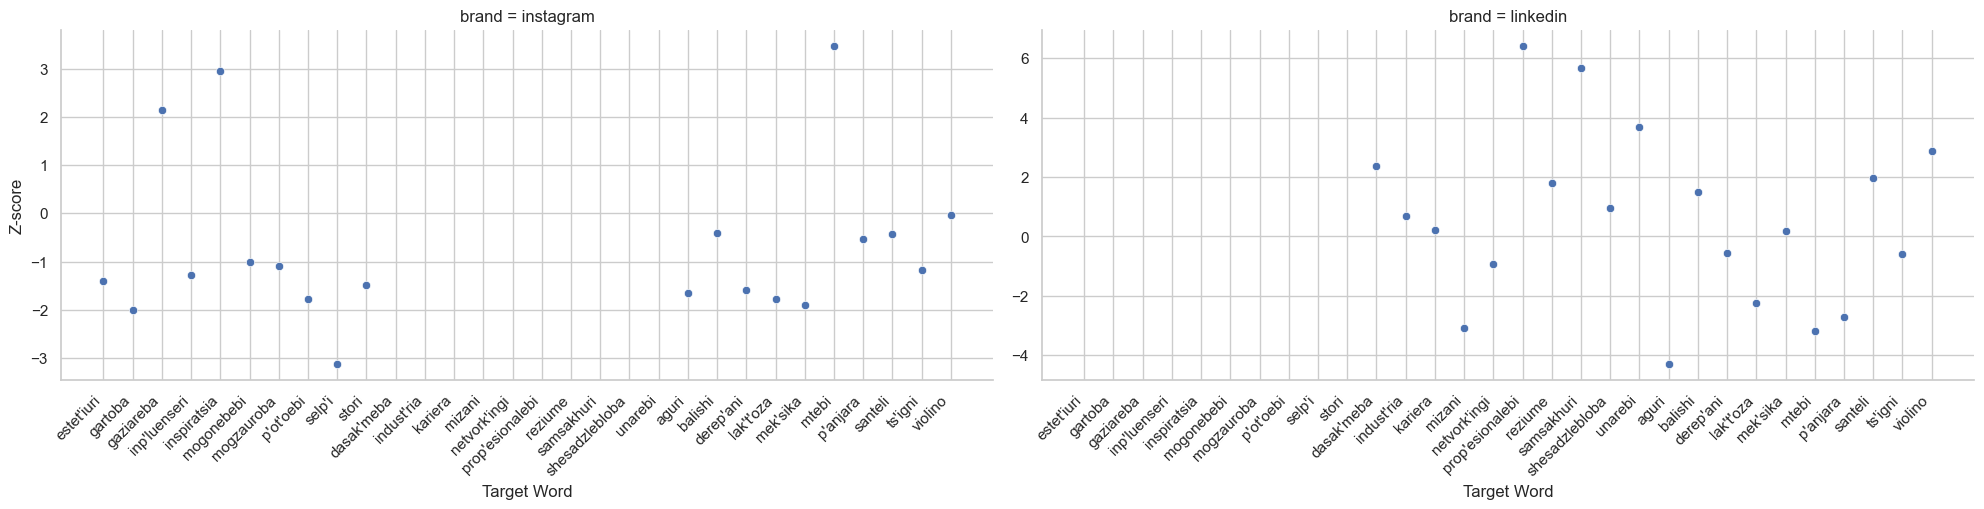

In [84]:
# Assuming pdata was created as described
# Reset index so 'brand' and 'target' become columns
pdata_reset = pdata.reset_index()

# Set plot style
sns.set(style="whitegrid")

# Alternative plot using zscore instead
g = sns.FacetGrid(pdata_reset, col="brand", height=5, sharey=False, aspect=2)
g.map_dataframe(sns.scatterplot, x="target_latin", y="zscore")
g.set_xticklabels(rotation=45, ha='right')
g.set_axis_labels("Target Word", "Z-score")
plt.subplots_adjust(hspace=0.3, bottom=0.25, top=0.95)
# plt.tight_layout()

In [85]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Assuming pdata was created as described
# # Reset index so 'brand' and 'target' become columns
# pdata_reset = pdata.reset_index()

# # Set plot style
# sns.set(style="whitegrid")

# # Alternative plot using zscore instead
# g = sns.FacetGrid(pdata_reset, col="brand", height=5, sharey=False, aspect=2)
# g.map_dataframe(sns.scatterplot, x="target_latin", y="zscore")
# g.set_xticklabels(rotation=45, ha='right')
# g.set_axis_labels("Target Word", "Z-score")
# plt.subplots_adjust(hspace=0.3, bottom=0.25, top=0.95)
# # plt.tight_layout()

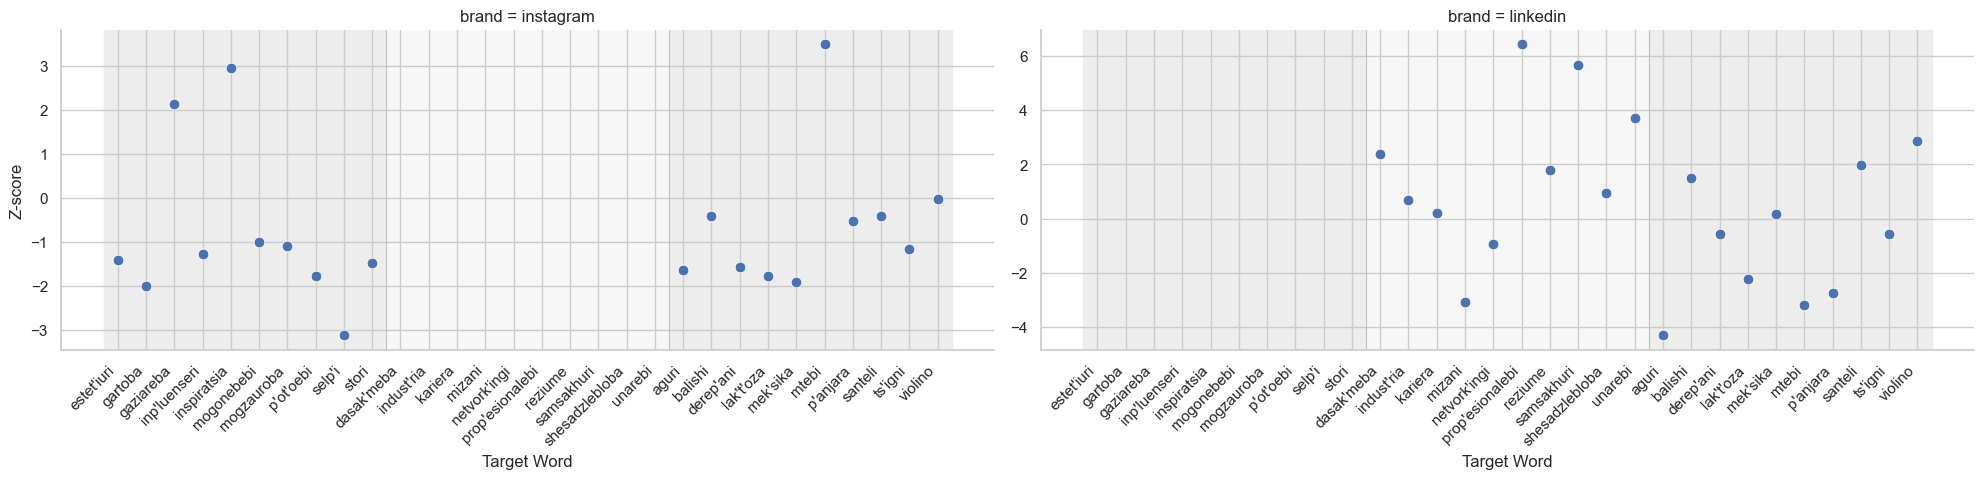

In [86]:
# Order targets by category and add category banding on the x-axis
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# pdata as in your code; reset for plotting
pdata_reset = pdata.reset_index()

# Category order
CAT_ORDER = ['instagram', 'linkedin', 'unrelated']

# Build target order within categories (alphabetical)
word_order = []
for c in CAT_ORDER:
    w = (pdata_reset.loc[pdata_reset['category'] == c, 'target_latin']
                     .drop_duplicates()
                     .sort_values(key=lambda s: s.str.lower()))
    word_order.extend(w.tolist())

# Encode ordered categories for x
pdata_reset['target_latin'] = pd.Categorical(pdata_reset['target_latin'],
                                             categories=word_order, ordered=True)
x_index = {w: i for i, w in enumerate(word_order)}
pdata_reset['x_pos'] = pdata_reset['target_latin'].map(x_index).astype(int)

# Precompute category intervals (start/end indices on x)
word2cat = dict(pdata_reset[['target_latin', 'category']].drop_duplicates().values)
bounds = []
start = 0
cur = word2cat[word_order[0]]
for i, w in enumerate(word_order):
    c = word2cat[w]
    if c != cur:
        bounds.append((cur, start, i - 1))
        cur, start = c, i
bounds.append((cur, start, len(word_order) - 1))

# Plot
sns.set(style="whitegrid")
g = sns.FacetGrid(pdata_reset, col="brand", height=5, sharey=False, aspect=2)
g.map_dataframe(sns.scatterplot, x="x_pos", y="zscore", s=60)

# Ax cosmetics: ticks, labels, category shading
for ax in g.axes.flat:
    # alternating category bands
    for j, (cat, a, b) in enumerate(bounds):
        ax.axvspan(a - 0.5, b + 0.5, color=str(0.93 + 0.04*(j % 2)), alpha=1.0, zorder=0)
        if j < len(bounds) - 1:
            ax.axvline(b + 0.5, color='0.75', lw=0.8, zorder=1)

    # ticks and ticklabels
    ax.set_xticks(np.arange(len(word_order)))
    ax.set_xticklabels(word_order, rotation=45, ha='right')

g.set_axis_labels("Target Word", "Z-score")
plt.subplots_adjust(hspace=0.35, bottom=0.28, top=0.92, wspace=0.05)
plt.show()

## Beamformer stLCMV

In [87]:
# --- compatibility patch for old-style LinearModel._preprocess_data used by posthoc.Beamformer ---
from sklearn.linear_model._base import LinearModel, _preprocess_data as _skl_preprocess_data

def _preprocess_data_compat(*args, **kwargs):
    # posthoc passes "normalize=...", which no longer exists; just drop it
    kwargs.pop("normalize", None)
    return _skl_preprocess_data(*args, **kwargs)

# attach as a staticmethod so calls like LinearModel._preprocess_data(...) work
LinearModel._preprocess_data = staticmethod(_preprocess_data_compat)
# --- end compatibility patch ---

import numpy as np
from posthoc import Beamformer
from posthoc.cov_estimators import ShrinkageKernel
from sklearn import metrics
from matplotlib import pyplot as plt

In [88]:
event_dict = dict(target=1)
# reject_criteria = dict(
#     eeg=100e-6,
# )
reject_criteria = None
raw_resampled, events_resampled = raw.copy().resample(50, events=events)
epochs = mne.Epochs(raw_resampled, events_resampled, event_dict, tmin=-0.2, tmax=1.01,
                    baseline=(-0.2, 0), preload=True, reject=reject_criteria)
unrel_epochs = epochs[unrelated]
rel_epochs = epochs[related]
merged_epochs = mne.concatenate_epochs([unrel_epochs, rel_epochs])
print(f"Using {len(epochs)} epochs for beamformer template.")

Not setting metadata
210 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 210 events and 61 original time points ...
0 bad epochs dropped
Not setting metadata
128 matching events found
Applying baseline correction (mode: mean)
Using 210 epochs for beamformer template.


In [89]:
unrelated, related

(array([  0,   7,   8,  13,  14,  18,  21,  25,  26,  30,  31,  33,  34,
         38,  39,  40,  42,  46,  52,  56,  57,  59,  63,  66,  72,  81,
         82,  87,  89,  91,  92,  96,  97, 101, 104, 109, 110, 114, 120,
        123, 124, 126, 129, 131, 132, 134, 135, 140, 143, 144, 155, 159,
        162, 166, 169, 170, 174, 177, 179, 183, 187, 199, 202, 208]),
 array([  3,   4,   6,  10,  15,  16,  19,  20,  22,  27,  28,  29,  36,
         41,  47,  48,  55,  58,  62,  65,  68,  69,  70,  71,  73,  75,
         76,  79,  80,  83,  84,  85,  93,  94,  95, 103, 105, 106, 107,
        108, 113, 117, 118, 125, 127, 136, 137, 138, 139, 146, 147, 148,
        149, 150, 153, 156, 157, 163, 168, 171, 178, 181, 190, 205]))

In [90]:
unrel_epochs.get_data().shape, rel_epochs.get_data().shape

((64, 8, 61), (64, 8, 61))

In [91]:
len(unrelated), len(related)

(64, 64)

In [92]:
X = merged_epochs.get_data().reshape(len(merged_epochs), -1)
y = np.array(len(unrel_epochs) * [1] + len(rel_epochs) * [2])
X.shape, y.shape

((128, 488), (128,))

In [93]:
evoked_unrel = X[y == 1].mean(axis=0)
evoked_rel = X[y == 2].mean(axis=0)
template = evoked_rel - evoked_unrel

Text(0.5, 1.0, 'Original template')

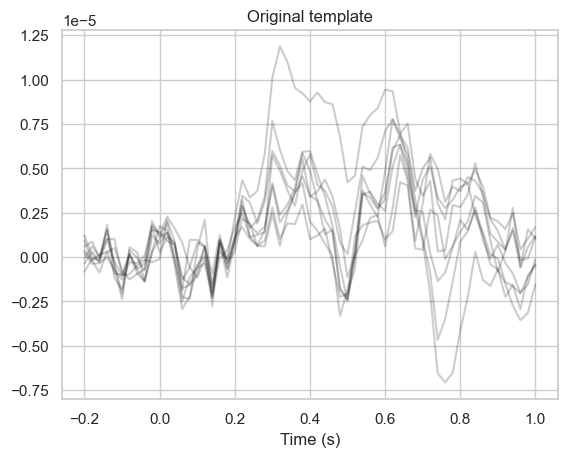

In [94]:
# This creates a (channels x time) view of the template
template_ch_time = template.reshape(epochs.info['nchan'], -1)
# Plot the template
plt.figure()
plt.plot(epochs.times, template_ch_time.T, color='black', alpha=0.2)
plt.xlabel('Time (s)')
plt.title('Original template')

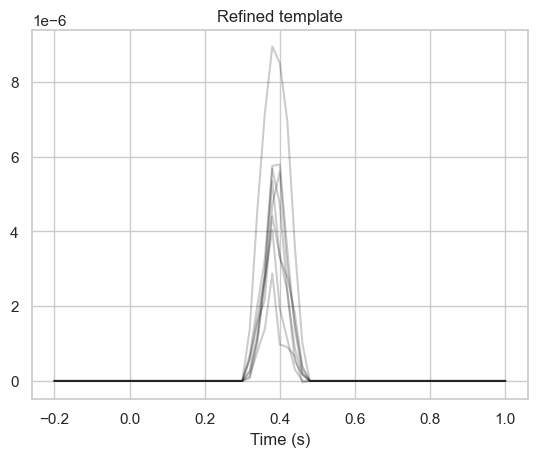

In [95]:
center = np.searchsorted(merged_epochs.times, 0.400)
width = 10
window = np.zeros(len(merged_epochs.times))
window[center - width // 2: center + width // 2] = np.hanning(width)
template_ch_time *= window[np.newaxis, :]
refined_template = template_ch_time.reshape(-1)

# Plot the refined template
plt.figure()
plt.plot(merged_epochs.times, template_ch_time.T, color='black', alpha=0.2)
plt.xlabel('Time (s)')
plt.title('Refined template')
plt.show()

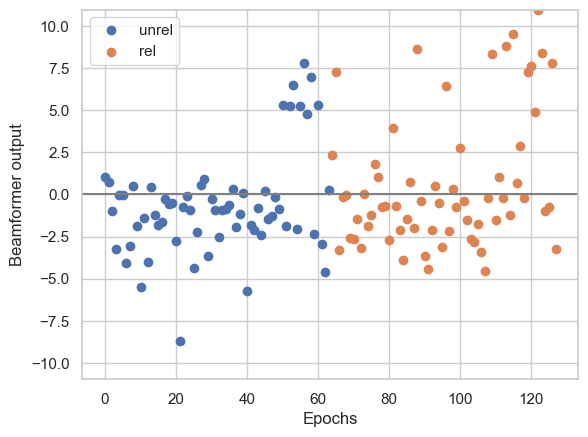

In [96]:
beamformer = Beamformer(refined_template, cov=ShrinkageKernel(1.0)).fit(X)

y_hat = beamformer.predict(X).ravel()

# Visualize the output of the LCMV beamformer
y_unrel = y_hat[y == 1]
y_rel = y_hat[y == 2]
lim = np.max(np.abs(y_hat))
plt.figure()
plt.scatter(np.arange(len(y_unrel)), y_unrel)
plt.scatter(np.arange(len(y_unrel), len(y_unrel) + len(y_rel)), y_rel)
plt.legend(['unrel', 'rel'])
plt.axhline(0, color='gray')
plt.ylim(-lim, lim)
plt.xlabel('Epochs')
plt.ylabel('Beamformer output')

# Assign the 'left' class to values above 0 and 'right' to values below 0
y_bin = np.zeros(len(y_hat), dtype=np.int32)
y_bin[y_hat >= 0] = 1
y_bin[y_hat < 0] = 2

### New script

In [ ]:
import numpy as np
from sklearn.covariance import LedoitWolf


#How much weight should each time point contribute to the N400 template ? 
# 1) "rect" = rectangular (uniform) window , Every time point between tmin and tmax is weighted equally, Everything outside is zero
# 2) "hann" - This creates a smooth, bell-shaped weighting inside the window, 0 at the edges, Maximum in the center, Smooth rise and fall

def make_temporal_window(times, tmin=0.30, tmax=0.50, kind="hann"):
    """Return a 1D window over time: zeros outside [tmin,tmax]."""
    mask = (times >= tmin) & (times <= tmax)
    w = np.zeros_like(times, dtype=float)
    if mask.sum() == 0:
        raise ValueError("No timepoints inside the requested window.")
    if kind == "hann":
        w[mask] = np.hanning(mask.sum())
    elif kind == "rect":
        w[mask] = 1.0
    else:
        raise ValueError("kind must be 'hann' or 'rect'.")
    return w, mask


def build_n400_template_from_unrelated(epochs, unrelated_idx, tmin=0.30, tmax=0.50, window_kind="hann"):
    """
    Build a spatio-temporal N400 template vector s from unrelated/incongruent trials.
    Template = average ERP of unrelated trials * temporal window in [tmin,tmax].

    Returns:
        s : (n_features,) where n_features = n_channels * n_times
    """
    X = epochs.get_data()  # (n_trials, n_ch, n_time)
    times = epochs.times
    n_ch, n_t = X.shape[1], X.shape[2]

    w_t, _ = make_temporal_window(times, tmin=tmin, tmax=tmax, kind=window_kind)

    # Average ERP across unrelated trials
    erp_unrel = X[unrelated_idx].mean(axis=0)  # (n_ch, n_time)

    # Apply temporal window to emphasize N400 range
    erp_unrel_win = erp_unrel * w_t[np.newaxis, :]  # (n_ch, n_time)

    # Flatten to feature vector
    s = erp_unrel_win.reshape(n_ch * n_t)

    # Normalize template to reduce scale issues (optional but helpful)
    s_norm = np.linalg.norm(s)
    if s_norm > 0:
        s = s / s_norm
    return s



#“How much does each trial look like the N400 template, after accounting for the covariance (noise structure) of the data?” , The output is: one scalar per trial → your single-trial N400 score
def st_lcmv_scores(epochs, template_s, cov_shrinkage=True, eps=1e-8):
    """
    Spatio-temporal LCMV/matched-filter score:
        w = R^{-1} s / (s^T R^{-1} s)
        score_i = x_i^T w

    epochs: mne.Epochs
    template_s: (n_features,)
    Returns:
        scores: (n_trials,)
    """
    X = epochs.get_data().reshape(len(epochs), -1)  # (n_trials, n_features)

    # Robust covariance
    if cov_shrinkage:
        R = LedoitWolf().fit(X).covariance_
    else:
        R = np.cov(X, rowvar=False)

    # Regularize
    R = R + eps * np.eye(R.shape[0])

    # Solve R^{-1} s efficiently
    s = template_s.reshape(-1, 1)
    Rinv_s = np.linalg.solve(R, s)  # (n_features, 1)

    denom = float(s.T @ Rinv_s)
    if denom == 0:
        raise ValueError("Template leads to zero denominator; check template/covariance.")

    w = (Rinv_s / denom).reshape(-1)  # (n_features,)
    scores = X @ w
    return scores


def compute_n400_beamformer(epochs, related_idx, unrelated_idx,
                            tmin=0.30, tmax=0.50, window_kind="hann",
                            cov_shrinkage=True, fix_sign=True):
    """
    Full pipeline for one subject:
      1) build template from unrelated
      2) compute single-trial scores for all epochs
      3) optional sign fix so unrelated is more negative than related
      4) z-score within subject
    """
    template_s = build_n400_template_from_unrelated(
        epochs, unrelated_idx, tmin=tmin, tmax=tmax, window_kind=window_kind
    )
    n400_raw = st_lcmv_scores(epochs, template_s, cov_shrinkage=cov_shrinkage)

    if fix_sign:
        # enforce: unrelated mean < related mean (more negative = bigger N400)
        if n400_raw[unrelated_idx].mean() > n400_raw[related_idx].mean():
            n400_raw *= -1.0

    # z-score within subject
    n400_z = (n400_raw - n400_raw.mean()) / (n400_raw.std(ddof=0) + 1e-12)
    return n400_raw, n400_z, template_s


In [ ]:
#This function builds an N400 template from unrelated trials, uses a noise-aware beamformer to compute a single N400 score for every trial, forces the score direction to match the classic N400 convention, and standardizes the scores so they’re comparable across subjects.

In [211]:
related_idx = np.sort(np.concatenate([ig_ig_idx, li_li_idx]))
unrelated_idx = np.sort(np.concatenate([ig_un_idx, li_un_idx]))


In [212]:
n400_raw, n400_z, template_s = compute_n400_beamformer(
    epochs,
    related_idx=related_idx,
    unrelated_idx=unrelated_idx,
    tmin=0.30, tmax=0.50,          # N400 window
    window_kind="hann",            # smooth window
    cov_shrinkage=True,
    fix_sign=True
)

# Attach to your csv_data (must be aligned with epochs)
csv_data = csv_data.reset_index(drop=True)
csv_data["n400_raw"] = n400_raw
csv_data["n400_z"] = n400_z


C:\Users\Gamge\AppData\Local\Temp\ipykernel_13900\883693856.py:75: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  denom = float(s.T @ Rinv_s)


In [215]:
csv_data

,timestamp_iso,trial_index,brand,target,prime_time_s,target_time_s,resp_window_s,resp_key,rt_ms_from_target,category,n400_raw,n400_z
0,2025-12-04T06:21:26.347,1,instagram,ლაიქი,0.16,0.16,1.5,right,1312.00,instagram,0.000077,1.298848
1,2025-12-04T06:21:29.261,2,instagram,სივი,0.16,0.16,1.5,NaN,NaN,linkedin,0.000013,0.259729
2,2025-12-04T06:21:32.191,3,instagram,ლურჯი,0.16,0.16,1.5,NaN,NaN,linkedin,0.000102,1.718872
3,2025-12-04T06:21:38.103,5,linkedin,ლაქტოზა,0.16,0.16,1.5,NaN,NaN,unrelated,-0.000011,-0.146889
4,2025-12-04T06:21:41.032,6,linkedin,ბალიში,0.16,0.16,1.5,left,1479.57,unrelated,-0.000004,-0.021892
...,...,...,...,...,...,...,...,...,...,...,...,...
103,2025-12-04T06:27:06.068,115,linkedin,აგური,0.16,0.16,1.5,left,313.33,unrelated,-0.000115,-1.844530
104,2025-12-04T06:27:08.965,116,instagram,აგური,0.16,0.16,1.5,right,267.84,unrelated,-0.000059,-0.935550
105,2025-12-04T06:27:11.879,117,instagram,რილსები,0.16,0.16,1.5,NaN,NaN,instagram,0.000064,1.085572
106,2025-12-04T06:27:14.793,118,instagram,ვიდეოები,0.16,0.16,1.5,NaN,NaN,instagram,0.000007,0.145705


In [213]:
import pandas as pd

all_df = []

for subject_id in ["S01", "S02", "S03"]:
    # You must load/preprocess/epoch per subject here
    # epochs, csv_data = ... (aligned!)
    # build your indices per subject from that subject's csv_data

    related_idx = np.sort(np.concatenate([ig_ig_idx, li_li_idx]))
    unrelated_idx = np.sort(np.concatenate([ig_un_idx, li_un_idx, ig_li_idx, li_ig_idx]))

    n400_raw, n400_z, _ = compute_n400_beamformer(epochs, related_idx, unrelated_idx)

    df = csv_data.reset_index(drop=True).copy()
    df["subject"] = subject_id
    df["n400_raw"] = n400_raw
    df["n400_z"] = n400_z
    all_df.append(df)

all_df = pd.concat(all_df, ignore_index=True)

# Now aggregate: per subject → per (brand,target) mean, then across subjects
pair_level = (all_df.groupby(["subject","brand","target"], as_index=False)
                   .agg(n400_pair=("n400_z","mean"), n_rep=("n400_z","size")))

group_level = (pair_level.groupby(["brand","target"], as_index=False)
                        .agg(n400_expected=("n400_pair","mean"),
                             n_sub=("n400_pair","count")))


C:\Users\Gamge\AppData\Local\Temp\ipykernel_13900\883693856.py:75: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  denom = float(s.T @ Rinv_s)
C:\Users\Gamge\AppData\Local\Temp\ipykernel_13900\883693856.py:75: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  denom = float(s.T @ Rinv_s)
C:\Users\Gamge\AppData\Local\Temp\ipykernel_13900\883693856.py:75: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  denom = float(s.T @ Rinv_s)


combining channels using "mean"
combining channels using "mean"


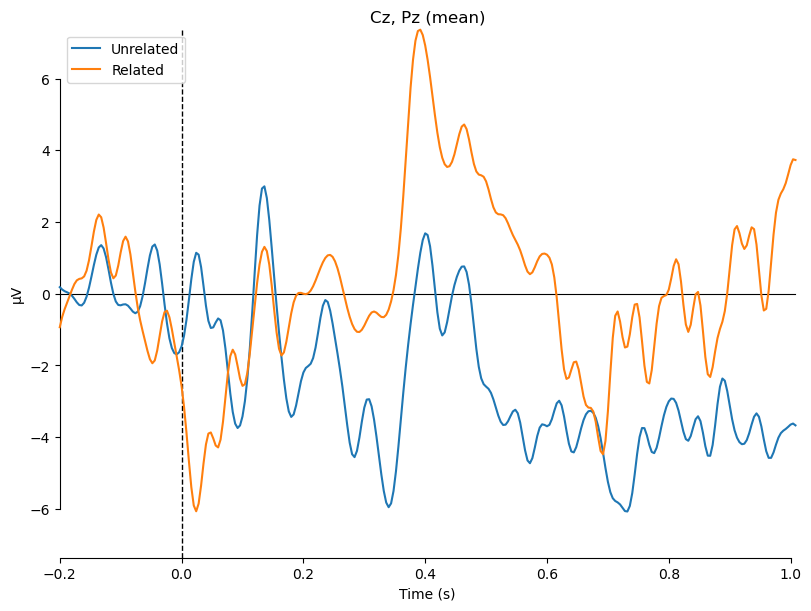

[<Figure size 800x600 with 1 Axes>]

In [214]:
import mne
mne.viz.plot_compare_evokeds(
    {"Unrelated": epochs[unrelated_idx].average(),
     "Related": epochs[related_idx].average()},
    picks=["Cz","Pz"], combine="mean"
)


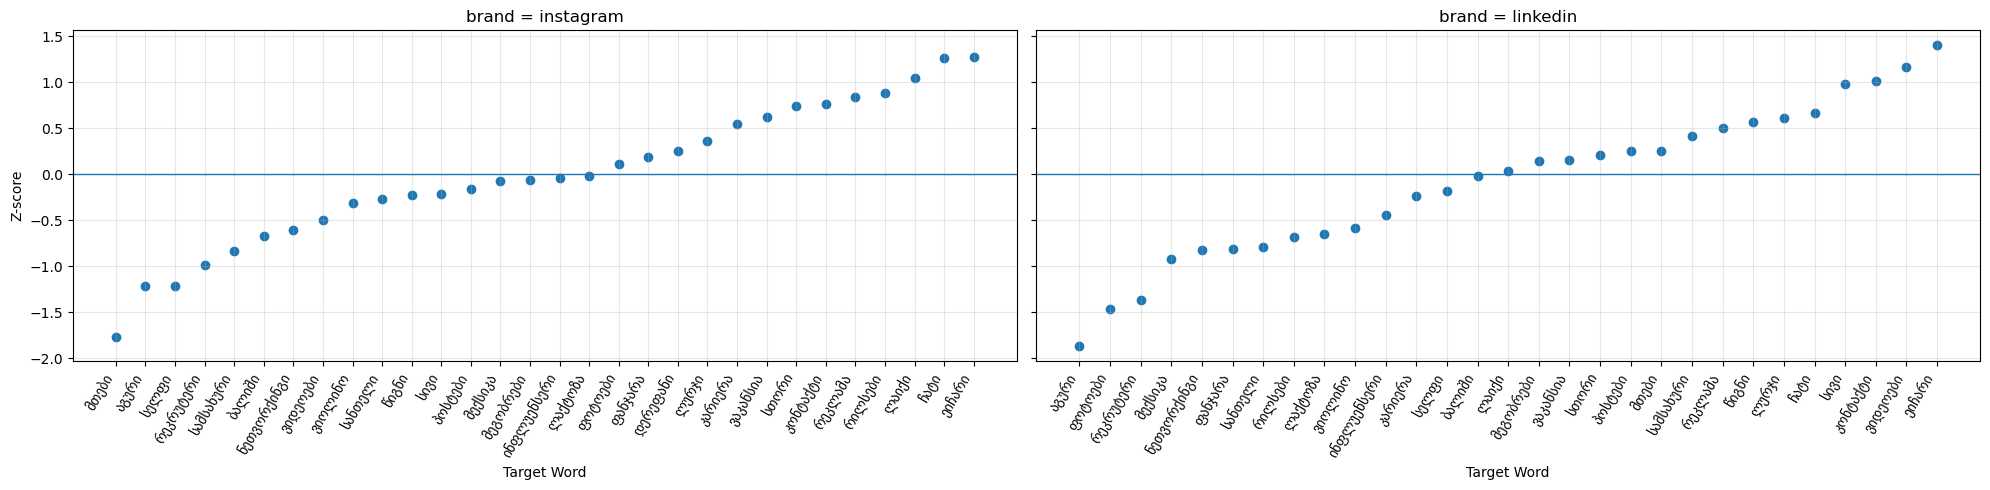

In [ ]:

def plot_brand_word_zscores(
    df,
    brand_col="brand",
    word_col="target",
    z_col="n400_z",
    brands=("instagram", "linkedin"),
    agg="mean",                # "mean" or "median"
    order="within_brand",      # "within_brand" or "global"
    figsize=(20, 5),
    title_prefix="brand = "
):
    """
    Plots word-level N400 z-scores per brand as two side-by-side scatter plots.

    df: pandas DataFrame containing brand, target word, and n400_z.
    agg: how to aggregate multiple trials per (brand, target) -> mean/median
    order:
      - "within_brand": order words separately in each panel by its own z (like your screenshot)
      - "global": use one shared word order (useful for comparing positions across panels)
    """

    d = df.copy()
    d[brand_col] = d[brand_col].astype(str).str.lower().str.strip()
    d[word_col] = d[word_col].astype(str).str.strip()

    if agg == "mean":
        word_stats = (d.groupby([brand_col, word_col], as_index=False)[z_col].mean())
    elif agg == "median":
        word_stats = (d.groupby([brand_col, word_col], as_index=False)[z_col].median())
    else:
        raise ValueError("agg must be 'mean' or 'median'")

    fig, axes = plt.subplots(1, len(brands), figsize=figsize, sharey=True)
    if len(brands) == 1:
        axes = [axes]

    # Global ordering (optional)
    if order == "global":
        global_order = (word_stats.groupby(word_col)[z_col].mean()
                        .sort_values(ascending=True).index.tolist())

    for ax, b in zip(axes, brands):
        sub = word_stats[word_stats[brand_col] == b].copy()
        if sub.empty:
            ax.set_title(f"{title_prefix}{b} (no data)")
            ax.axis("off")
            continue

        if order == "within_brand":
            sub = sub.sort_values(z_col, ascending=True)
            word_order = sub[word_col].tolist()
        elif order == "global":
            # keep only words present for this brand
            word_order = [w for w in global_order if w in set(sub[word_col])]
            sub[word_col] = pd.Categorical(sub[word_col], categories=word_order, ordered=True)
            sub = sub.sort_values(word_col)
        else:
            raise ValueError("order must be 'within_brand' or 'global'")

        x = np.arange(len(sub))
        y = sub[z_col].to_numpy()

        ax.scatter(x, y)
        ax.axhline(0, linewidth=1)
        ax.set_title(f"{title_prefix}{b}")
        ax.set_xlabel("Target Word")
        ax.set_xticks(x)
        ax.set_xticklabels(sub[word_col].tolist(), rotation=60, ha="right")
        ax.grid(True, axis="both", alpha=0.3)

    axes[0].set_ylabel("Z-score")
    plt.tight_layout()
    return fig, axes


# --- Example usage ---
# Assumes you already have csv_data with columns: brand, target, n400_z
fig, axes = plot_brand_word_zscores(csv_data)
plt.show()


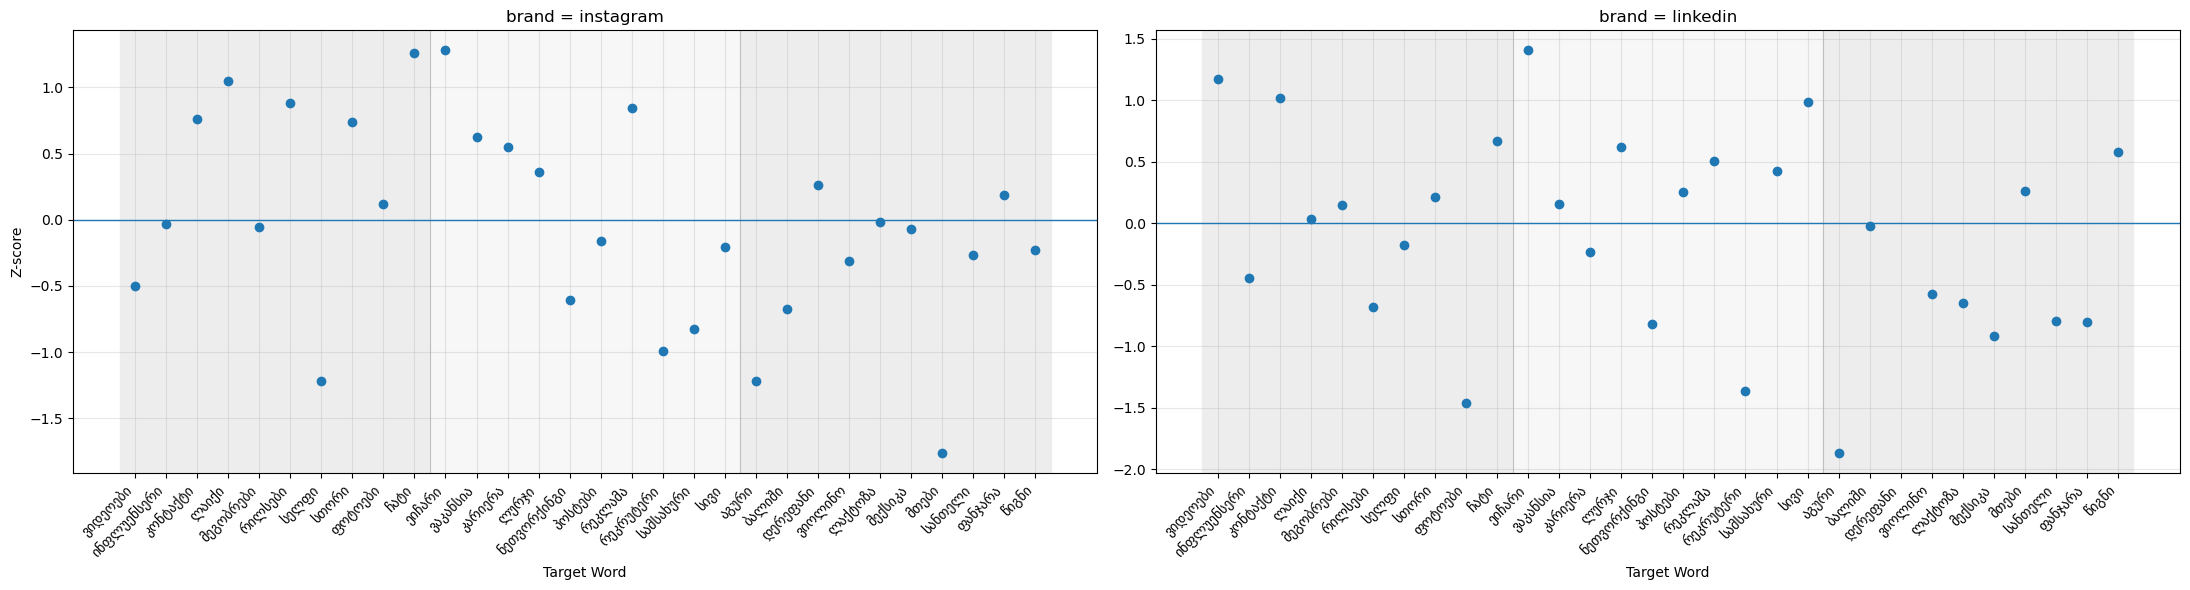

In [ ]:
def plot_brand_word_zscores_banded(
    df,
    brand_col="brand",
    category_col="category",
    word_col="target_latin",
    z_col="zscore",
    brands=("instagram", "linkedin"),
    cat_order=("instagram", "linkedin", "unrelated"),
    agg="mean",              # "mean" or "median" if you have repeats
    sharey=False,
    figsize=(22, 6),
    rotation=45
):
    """
    Matplotlib version of your FacetGrid plot with:
      - global word order grouped by category and alphabetical within category
      - category shading bands and vertical dividers
      - one subplot per brand

    If df contains multiple rows per (brand, word), set agg="mean" or "median".
    """

    d = df.copy()

    # --- normalize text fields ---
    d[brand_col] = d[brand_col].astype(str).str.lower().str.strip()
    d[category_col] = d[category_col].astype(str).str.lower().str.strip()
    d[word_col] = d[word_col].astype(str).str.strip()

    # --- optional aggregation to one point per (brand, category, word) ---
    if agg is not None:
        if agg == "mean":
            d = (d.groupby([brand_col, category_col, word_col], as_index=False)[z_col]
                   .mean())
        elif agg == "median":
            d = (d.groupby([brand_col, category_col, word_col], as_index=False)[z_col]
                   .median())
        else:
            raise ValueError("agg must be None, 'mean', or 'median'.")

    # --- build GLOBAL word order: by category blocks then alphabetical ---
    word_order = []
    for c in cat_order:
        w = (d.loc[d[category_col] == c, word_col]
               .drop_duplicates()
               .sort_values(key=lambda s: s.str.lower()))
        word_order.extend(w.tolist())

    if len(word_order) == 0:
        raise ValueError("No words found. Check category labels and word column.")

    # Map each word to a global x position
    x_index = {w: i for i, w in enumerate(word_order)}
    d["x_pos"] = d[word_col].map(x_index)

    # --- compute category bounds for shading ---
    # (word -> category) mapping (assumes each word belongs to one category)
    word2cat = (d[[word_col, category_col]]
                .drop_duplicates()
                .set_index(word_col)[category_col]
                .to_dict())

    bounds = []
    start = 0
    cur_cat = word2cat[word_order[0]]
    for i, w in enumerate(word_order):
        c = word2cat[w]
        if c != cur_cat:
            bounds.append((cur_cat, start, i - 1))
            cur_cat, start = c, i
    bounds.append((cur_cat, start, len(word_order) - 1))

    # --- plotting ---
    fig, axes = plt.subplots(1, len(brands), figsize=figsize, sharey=sharey)
    if len(brands) == 1:
        axes = [axes]

    for ax, b in zip(axes, brands):
        sub = d[d[brand_col] == b].copy()

        # category shading bands + dividers
        for j, (cat, a, bnd) in enumerate(bounds):
            # alternating light grays (no hard-coded colors, just grayscale)
            gray = 0.93 + 0.04 * (j % 2)
            ax.axvspan(a - 0.5, bnd + 0.5, color=str(gray), alpha=1.0, zorder=0)
            if j < len(bounds) - 1:
                ax.axvline(bnd + 0.5, color="0.75", lw=0.8, zorder=1)

        # scatter points
        ax.scatter(sub["x_pos"].to_numpy(), sub[z_col].to_numpy(), zorder=2)

        # axis cosmetics
        ax.axhline(0, lw=1)
        ax.set_title(f"brand = {b}")
        ax.set_xlabel("Target Word")
        ax.grid(True, axis="both", alpha=0.3)

        ax.set_xticks(np.arange(len(word_order)))
        ax.set_xticklabels(word_order, rotation=rotation, ha="right")

    axes[0].set_ylabel("Z-score")
    plt.tight_layout()
    return fig, axes


# -------------------------
# Example usage
# -------------------------
# If your dataframe is csv_data with columns: brand, target, n400_z
# You can adapt like this:
#
pdata = csv_data.rename(columns={"target": "target_latin", "n400_z": "zscore"})
fig, axes = plot_brand_word_zscores_banded(
    pdata,
    brand_col="brand",
    category_col="category",      # must exist
    word_col="target_latin",
    z_col="zscore",
    brands=("instagram", "linkedin"),
    cat_order=("instagram", "linkedin", "unrelated"),
    agg="mean",
    sharey=False
)
plt.show()


In [221]:
qc = (csv_data
      .assign(has_resp=csv_data["resp_key"].notna())
      .groupby(["brand","category"], as_index=False)
      .agg(n_trials=("trial_index","count"),
           n_resp=("has_resp","sum"),
           mean_rt=("rt_ms_from_target","mean"),
           mean_n400=("n400_z","mean"),
           std_n400=("n400_z","std")))
qc


,brand,category,n_trials,n_resp,mean_rt,mean_n400,std_n400
0,instagram,instagram,19,16,682.206875,0.276368,1.056693
1,instagram,linkedin,17,14,826.161429,0.244446,0.894085
2,instagram,unrelated,19,18,791.645556,-0.339651,0.875105
3,linkedin,instagram,18,14,903.835714,0.123576,0.812954
4,linkedin,linkedin,19,14,670.937857,0.189335,1.152242
5,linkedin,unrelated,16,13,942.229231,-0.548434,1.025214


In [222]:
word_level = (csv_data.groupby(["brand","target","category"], as_index=False)
              .agg(n400_word=("n400_z","mean"),
                   n_rep=("n400_z","size"),
                   rt_mean=("rt_ms_from_target","mean")))
word_level

,brand,target,category,n400_word,n_rep,rt_mean
0,instagram,აგური,unrelated,-1.217519,2,649.545
1,instagram,ბალიში,unrelated,-0.671663,2,863.690
2,instagram,დერეფანი,unrelated,0.259783,2,729.430
3,instagram,ეიჩარი,linkedin,1.278629,2,945.910
4,instagram,ვაკანსია,linkedin,0.621984,2,289.170
5,instagram,ვიდეოები,instagram,-0.500307,2,748.560
6,instagram,ვიოლინო,unrelated,-0.311279,2,388.685
7,instagram,ინფლუენსერი,instagram,-0.033413,2,753.905
8,instagram,კარიერა,linkedin,0.552112,2,1129.860
9,instagram,კონტაქტი,instagram,0.761734,1,762.790


In [223]:
csv_data["split"] = np.where(csv_data["trial_index"] % 2 == 0, "even", "odd")

wl_split = (csv_data.groupby(["split","brand","target"], as_index=False)
            .agg(n400=("n400_z","mean")))

pivot = wl_split.pivot_table(index=["brand","target"], columns="split", values="n400")
r = pivot.corr().loc["odd","even"]
print("Odd-even word-score correlation:", r)


Odd-even word-score correlation: -0.06380561971210329


In [ ]:
all_subjects = []   


for subj in all_df["subject"].unique():
    df_s = all_df[all_df["subject"] == subj]

    
        # ---- load / compute subject data ----
        # csv_data = ... (your existing per-subject pipeline)
        # IMPORTANT: n400_z must already be computed per subject
        
        csv_data = csv_data.copy()   # safety
        csv_data["subject"] = subj   # tag subject
        
        all_subjects.append(csv_data)
    
    all_df = pd.concat(all_subjects, ignore_index=True)
    
    print(all_df["subject"].value_counts())